In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import math
import scipy as sp
from statsmodels import regression
import xlsxwriter
import random
import datetime

import sqlite3
from sqlite3 import Error
from collections import OrderedDict


# Data Preparation

In [94]:
pd.set_option("display.precision", 8)

#Load data from Excel into a dataframe
data = pd.read_excel('Data.xlsx', index_col=0, skiprows=0)
data.dropna(axis = 0,inplace= True)

# Format dates column in dataframe for SQL storage
data.index = pd.to_datetime(data.index, format='%Y-%m-%d').strftime('%Y-%m-%d %H-%M-%S')
data.head(5)

,SMI Index,CCMP Index,DAX Index,UKX Index,EURUSD Curncy,CHFEUR Curncy,CHFUSD Curncy,CL1 Comdty,XAU Comdty,XAG Comdty,CPI CHNG Index,USERTOT Index,NAPMNMI Index,RSTAMOM Index,M2 Index,EUITEMU Index,CPMINORD Index,USGG10YR Index,CONSSENT Index,CONCCONF Index
Dates,,,,,,,,,,,,,,,,,,,,
2011-01-31 00-00-00,6479.15,2700.08,7077.48,5862.94,1.3698,0.7760,1.0628,92.19,1337.14,28.3900,0.3,58.3,57.6,0.8,8823.2,99.2,54.9,3.3704,74.2,64.79
2011-02-28 00-00-00,6610.44,2782.27,7272.32,5994.01,1.3792,0.7800,1.0758,96.97,1411.88,33.8894,0.3,58.4,58.0,0.8,8887.0,100.1,54.3,3.4272,77.5,72.02
2011-03-31 00-00-00,6357.55,2781.07,7041.31,5908.76,1.4190,0.7695,1.0920,106.72,1437.78,37.7175,0.5,58.4,55.8,0.9,8943.4,100.3,55.2,3.4703,67.5,63.82
2011-04-29 00-00-00,6539.70,2873.54,7514.46,6069.90,1.4807,0.7804,1.1557,113.93,1563.70,47.9050,0.5,58.4,55.2,0.5,9004.9,99.8,53.8,3.2863,69.8,66.02
2011-05-31 00-00-00,6554.71,2835.30,7293.69,5989.99,1.4369,0.8156,1.1718,102.70,1536.23,38.1738,0.3,58.3,55.0,0.0,9075.5,100.4,52.1,3.0607,74.3,61.74


# Data Processing - Split data into 4 subsets

In [95]:
# Create smaller datasets by selecting dates from the index
sample_1 = data[0:30] # 01.01.2011 - 28.06.2013
sample_2 = data[30:60] # 01.07.2013 - 31.12.2015
sample_3 = data[60:90] # 01.01.2016 - 29.06.2018
sample_4 = data[90:120] # 01.07.2018 - 31.12.2020
dataSets = [sample_1, sample_2, sample_3, sample_4]


# Transform dataframe of subsets into a list so it can be inserted into a SQL database
recordsSample1 = sample_1.reset_index().values.tolist()
recordsSample2 = sample_2.reset_index().values.tolist()
recordsSample3 = sample_3.reset_index().values.tolist()
recordsSample4 = sample_4.reset_index().values.tolist()
recordsSample1


[['2011-01-31 00-00-00',
  6479.15,
  2700.08,
  7077.48,
  5862.94,
  1.3698000000000001,
  0.776,
  1.0628,
  92.19,
  1337.14,
  28.39,
  0.3,
  58.3,
  57.6,
  0.8,
  8823.2,
  99.2,
  54.9,
  3.3704,
  74.2,
  64.79],
 ['2011-02-28 00-00-00',
  6610.44,
  2782.27,
  7272.32,
  5994.01,
  1.3792,
  0.78,
  1.0758,
  96.97,
  1411.88,
  33.8894,
  0.3,
  58.4,
  58.0,
  0.8,
  8887.0,
  100.1,
  54.3,
  3.4272,
  77.5,
  72.02],
 ['2011-03-31 00-00-00',
  6357.55,
  2781.07,
  7041.31,
  5908.76,
  1.419,
  0.7695,
  1.092,
  106.72,
  1437.78,
  37.7175,
  0.5,
  58.4,
  55.8,
  0.9,
  8943.4,
  100.3,
  55.2,
  3.4703,
  67.5,
  63.82],
 ['2011-04-29 00-00-00',
  6539.7,
  2873.54,
  7514.46,
  6069.9,
  1.4807000000000001,
  0.7804,
  1.1557,
  113.93,
  1563.7,
  47.905,
  0.5,
  58.4,
  55.2,
  0.5,
  9004.9,
  99.8,
  53.8,
  3.2862999999999998,
  69.8,
  66.02],
 ['2011-05-31 00-00-00',
  6554.71,
  2835.3,
  7293.69,
  5989.99,
  1.4369,
  0.8156,
  1.1718,
  102.7,
  1536.2

# SQL Connection

## Check main connection to SQL

In [96]:
""" create a database connection tool to a SQLite database """

def create_connection(db_file):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print(sqlite3.version)
    except Error as e:
        print(e)
    finally:
        if conn:
            conn.close()
 
 
if __name__ == '__main__':
    create_connection(r"database.db")



2.6.0


## SQL - Create tables for subsets and results

In [97]:
def createTableSample(tableName):
    conn = sqlite3.connect(r"database.db")
    c = conn.cursor()
    c.execute('''CREATE TABLE if not exists ''' + tableName + '''
             (id INTEGER PRIMARY KEY,
             Dates TIMESTAMP,
             SMI           INT    NOT NULL,
             CCMP            INT     NOT NULL,
             DAX INT NOT NULL,
             UKX INT NOT NULL,
             EURUSD INT NOT NULL,
             CHFEUR INT NOT NULL,
             CHFUSD INT NOT NULL,
             CL1 INT NOT NULL,
             XAU INT NOT NULL,
             XAG INT NOT NULL,
             CPI CHNG INT NOT NULL,
             USERTOT INT NOT NULL,
             NAPMNMI INT NOT NULL,
             RSTAMOM INT NOT NULL,
             M2 INT NOT NULL,
             EUITEMU INT NOT NULL,
             PMINORD INT NOT NULL,
             USGG10YR INT NOT NULL,
             CONSSENT INT NOT NULL,
             CONCCONF INT)''')
    print('Table', tableName, 'created successfully')
    
def storeDataTableSample(tableName, records):
    conn = sqlite3.connect(r"database.db")
    c = conn.cursor()
    c.executemany('INSERT INTO ' + tableName + '(Dates,SMI,CCMP,DAX,UKX,EURUSD,CHFEUR,CHFUSD,CL1,XAU,XAG,CPI,USERTOT,NAPMNMI,RSTAMOM,M2,EUITEMU,PMINORD,USGG10YR,CONSSENT,CONCCONF) VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)', records) 
    conn.commit()
    print('Data successfully inserted into table', tableName)

createTableSample('Sample1')
createTableSample('Sample2')
createTableSample('Sample3')
createTableSample('Sample4')

storeDataTableSample('Sample1', recordsSample1)
storeDataTableSample('Sample2', recordsSample2)
storeDataTableSample('Sample3', recordsSample3)
storeDataTableSample('Sample4', recordsSample4)


Table Sample1 created successfully
Table Sample2 created successfully
Table Sample3 created successfully
Table Sample4 created successfully
Data successfully inserted into table Sample1
Data successfully inserted into table Sample2
Data successfully inserted into table Sample3
Data successfully inserted into table Sample4


# Store Descriptiv Statistic of data sets

In [98]:
# Store in database
sample_1.describe()
sample_2.describe()
sample_3.describe()
sample_4.describe()

,SMI Index,CCMP Index,DAX Index,UKX Index,EURUSD Curncy,CHFEUR Curncy,CHFUSD Curncy,CL1 Comdty,XAU Comdty,XAG Comdty,CPI CHNG Index,USERTOT Index,NAPMNMI Index,RSTAMOM Index,M2 Index,EUITEMU Index,CPMINORD Index,USGG10YR Index,CONSSENT Index,CONCCONF Index
count,30.00000000,30.00000000,30.00000000,30.00000000,30.00000000,30.00000000,30.00000000,30.00000000,30.00000000,30.00000000,30.00000000,30.00000000,30.00000000,30.00000000,30.00000000,30.00000000,30.00000000,30.00000000,30.00000000,30.00000000
mean,9744.96400000,8826.97633333,12114.21833333,6830.44133333,1.13614000,0.90998333,1.03376333,50.72666667,1518.28866667,17.79993000,0.14333333,59.11666667,55.77666667,0.35333333,15856.89333333,100.69000000,50.47000000,1.74843000,90.63000000,118.35666667
std,577.41683142,1617.06125322,873.57878987,667.78051518,0.03396621,0.02440263,0.03897687,13.02946114,252.26468222,3.90993074,0.24730734,2.70237231,3.88318065,4.95919441,1752.45241422,7.06898764,4.17423542,0.89217549,10.03432557,18.20863159
min,8429.30000000,6635.28000000,9935.84000000,5577.27000000,1.09030000,0.86320000,0.98160000,18.84000000,1192.52000000,14.03740000,-0.70000000,51.30000000,41.60000000,-14.70000000,14159.40000000,74.50000000,29.30000000,0.52820000,71.80000000,85.70000000
25%,9331.17500000,7707.40500000,11533.65000000,6193.85250000,1.11077500,0.88882500,1.00510000,43.14750000,1295.68000000,14.97625000,0.02500000,57.40000000,55.15000000,-0.20000000,14501.52500000,100.02500000,49.90000000,0.84760000,80.97500000,101.32500000
50%,9831.26000000,8142.48000000,12278.83000000,7101.41500000,1.12745000,0.91430000,1.02150000,53.64500000,1491.47500000,16.50745000,0.20000000,60.55000000,56.50000000,0.35000000,15093.40000000,103.55000000,51.25000000,1.73340000,95.85000000,126.45000000
75%,10121.25000000,9405.13750000,12794.30750000,7392.79000000,1.16035000,0.92947500,1.03965000,58.55250000,1719.62000000,18.17942500,0.20000000,60.77500000,57.20000000,0.77500000,17680.47500000,104.92500000,52.00000000,2.59742500,98.37500000,131.37500000
max,10703.51000000,12888.28000000,13718.78000000,7748.76000000,1.22250000,0.94610000,1.13020000,73.25000000,1975.86000000,28.28700000,0.50000000,61.10000000,60.90000000,18.10000000,19125.80000000,106.10000000,53.90000000,3.14350000,101.00000000,137.90000000


In [256]:
# Pivot table of dataframe 
sample_3.pivot

<bound method DataFrame.pivot of                      SMI Index  CCMP Index  DAX Index  UKX Index  \
Dates                                                              
2016-01-29 00-00-00    8319.81     4613.95    9798.11    6083.79   
2016-02-29 00-00-00    7843.63     4557.95    9495.40    6097.09   
2016-03-31 00-00-00    7807.89     4869.85    9965.51    6174.90   
2016-04-29 00-00-00    7960.85     4775.36   10038.97    6241.89   
2016-05-31 00-00-00    8216.42     4948.06   10262.74    6230.79   
2016-06-30 00-00-00    8020.15     4842.67    9680.09    6504.33   
2016-07-29 00-00-00    8127.20     5162.13   10337.50    6724.43   
2016-08-31 00-00-00    8202.13     5213.22   10592.69    6781.51   
2016-09-30 00-00-00    8139.01     5312.00   10511.02    6899.33   
2016-10-31 00-00-00    7827.74     5189.14   10665.01    6954.22   
2016-11-30 00-00-00    7875.19     5323.68   10640.30    6783.79   
2016-12-30 00-00-00    8219.87     5383.12   11481.06    7142.83   
2017-01-31 00-0

# Normality Test - Create Histograms

In [249]:
for col in data.iteritems(): 
    print('histogram'+col[0])
    fig, ax = plt.subplots()
    indicator=data[col[0]]
    ax.hist(indicator, alpha=0.9, color='blue',bins=20)
    plt.title(col[0])
    plt.savefig('Charts/Hist_'+col[0]+'.png')
    plt.close()

histogramSMI Index
histogramCCMP Index
histogramDAX Index
histogramUKX Index
histogramEURUSD Curncy
histogramCHFEUR Curncy
histogramCHFUSD Curncy
histogramCL1 Comdty
histogramXAU Comdty
histogramXAG Comdty
histogramCPI CHNG Index
histogramUSERTOT Index
histogramNAPMNMI Index
histogramRSTAMOM Index
histogramM2 Index
histogramEUITEMU Index
histogramCPMINORD Index
histogramUSGG10YR Index
histogramCONSSENT Index
histogramCONCCONF Index
histogramconst


# Stationary Test

In [99]:
# Add every column name in a new list
columns = data.columns.tolist()
# Separate asset and macro data
assetColumns = columns[:10]
macroColumns = columns[10:20]

for i in range(len(dataSets)):
    print('Subset', i + 1, '\n')
    print('------------------------')
    for j in assetColumns:
        # ADF Test with 1 lag and constant regression model
        stationaryResult = adfuller(dataSets[i][j])
        if (stationaryResult[1] < 0.1):
            print(j, 'is stationary, because p-value of', stationaryResult[1], 'is < 0.1 --> 90% significant')
        else:
            print(j, 'is NOT stationary, because p-value of', stationaryResult[1], 'is >= 0.1')
    print('------------------------ \n')

Subset 1 

------------------------
(0.028741811031937077, 0.9608454461116381, 0, 29, {'1%': -3.6790595944893187, '5%': -2.9678817237279103, '10%': -2.6231583472057074}, 270.85831943462915)
SMI Index is NOT stationary, because p-value of 0.9608454461116381 is >= 0.1
(-0.6757596076159192, 0.8529288385236653, 0, 29, {'1%': -3.6790595944893187, '5%': -2.9678817237279103, '10%': -2.6231583472057074}, 245.23947374524306)
CCMP Index is NOT stationary, because p-value of 0.8529288385236653 is >= 0.1
(-1.1798092640516964, 0.6822203990826865, 0, 29, {'1%': -3.6790595944893187, '5%': -2.9678817237279103, '10%': -2.6231583472057074}, 282.09321731656576)
DAX Index is NOT stationary, because p-value of 0.6822203990826865 is >= 0.1
(-1.3954991723853047, 0.5844319596144637, 0, 29, {'1%': -3.6790595944893187, '5%': -2.9678817237279103, '10%': -2.6231583472057074}, 266.0241439800854)
UKX Index is NOT stationary, because p-value of 0.5844319596144637 is >= 0.1
(-1.6152501323085313, 0.4752203331919417, 0

(-1.9666768555888618, 0.30137248867215927, 0, 29, {'1%': -3.6790595944893187, '5%': -2.9678817237279103, '10%': -2.6231583472057074}, 140.87173549846423)
CL1 Comdty is NOT stationary, because p-value of 0.30137248867215927 is >= 0.1
(2.4414754710129385, 0.9990285106264699, 9, 20, {'1%': -3.8092091249999998, '5%': -3.0216450000000004, '10%': -2.6507125}, 227.51318635202816)
XAU Comdty is NOT stationary, because p-value of 0.9990285106264699 is >= 0.1
(-0.5927375168633193, 0.872614620566071, 0, 29, {'1%': -3.6790595944893187, '5%': -2.9678817237279103, '10%': -2.6231583472057074}, 94.30334644876012)
XAG Comdty is NOT stationary, because p-value of 0.872614620566071 is >= 0.1
------------------------ 



# Chow Test - Function

In [100]:
def chowTest(regressionArray, xArray, regressionGroupId):
    
    # Whole time series
    RSSd = regressionArray[0].ssr

    # Sample 1 --> subset 1
    RSSb1 = regressionArray[1].ssr
 
    # Sample 2 --> subset 2
    RSSb2 = regressionArray[2].ssr

    # Sample 3 --> subset 3
    RSSb3 = regressionArray[3].ssr

    # Sample 4 --> subset 4
    RSSb4 = regressionArray[4].ssr
    
    #J-Variable (1)
    J = xArray[0].shape[1] #one for all

    #k-Variables (4)
    k1 = xArray[1].shape[1] #Sample 1
    k2 = xArray[2].shape[1] #Sample 2
    k3 = xArray[3].shape[1] #Sample 3
    k4 = xArray[4].shape[1] #Sample 4

    #N1-Variables (4)
    N1 = xArray[1].shape[0] #Sample 1
    N2 = xArray[2].shape[0] #Sample 2
    N3 = xArray[3].shape[0] #Sample 3
    N4 = xArray[4].shape[0] #Sample 4
    
    # Regression Subset 1 + 2
    
    chow1 = ((RSSd-(RSSb1+RSSb2))/J)/((RSSb1+RSSb2)/(N1+N2-2*k1))
    chow1 = sp.stats.f.cdf(chow1, J, N1+N2-2*k1)
    
    # Regression Subset 2 + 3
    
    chow2 = ((RSSd-(RSSb2+RSSb3))/J)/((RSSb2+RSSb3)/(N2+N3-2*k2))
    chow2 = sp.stats.f.cdf(chow2, J, N2+N3-2*k2)

    # Regression Subset 3 + 4
    
    chow3 = ((RSSd-(RSSb3+RSSb4))/J)/((RSSb3+RSSb4)/(N3+N4-2*k3))
    chow3 = sp.stats.f.cdf(chow3, J, N3+N4-2*k3)

    # Regression Subset 1 + 3
    
    chow4 = ((RSSd-(RSSb1+RSSb3))/J)/((RSSb1+RSSb3)/(N1+N3-2*k1))
    chow4 = sp.stats.f.cdf(chow4, J, N1+N3-2*k1)

    # Regression Subset 1 + 4
    
    chow5 = ((RSSd-(RSSb1+RSSb4))/J)/((RSSb1+RSSb4)/(N1+N4-2*k1))
    chow5 = sp.stats.f.cdf(chow5, J, N1+N4-2*k1)

    # Regression Subset 2 + 4
    
    chow6 = ((RSSd-(RSSb2+RSSb4))/J)/((RSSb2+RSSb4)/(N2+N4-2*k2))
    chow6 = sp.stats.f.cdf(chow6, J, N2+N4-2*k2)

    print("Chow Test - Regression Model Subset 1 + 2:", chow1)
    print("Chow Test - Regression Model Subset 2 + 3:", chow2)
    print("Chow Test - Regression Model Subset 3 + 4:", chow3)
    print("Chow Test - Regression Model Subset 1 + 3:", chow4)
    print("Chow Test - Regression Model Subset 1 + 4:", chow5)
    print("Chow Test - Regression Model Subset 2 + 4:", chow6)
    
    chowResults = np.array([chow1,chow2,chow3,chow4,chow5,chow6,regressionGroupId])
    storeChowTestResult(chowResults.tolist())
    

# Rolling Regression - Function

In [101]:
def rolling_regression(y, x, window):
    estimate_data = []
    for i in range(window, x.index.size+1):
        x_slice = x.values[i-window:i,:] # always index in np as opposed to pandas, much faster
        y_slice = y.values[i-window:i]
        coeff = np.dot(np.dot(np.linalg.inv(np.dot(x_slice.T, x_slice)), x_slice.T), y_slice)
        estimate_data.append(coeff[0] * x.values[window-1] + coeff[1])
        # === Assemble ========================================================
    estimate = pd.Series(data=estimate_data, index=x.index[window-1:]) 
    return estimate

# Multiple Linear Regression Model - OLS

## Regression - SQL preparation

In [102]:
def createTableRegression():
    conn = sqlite3.connect(r"database.db")
    conn.execute("PRAGMA foreign_keys = 1")
    c = conn.cursor()
    c.execute('''CREATE TABLE if not exists RegressionModelResult
             (
             id INTEGER PRIMARY KEY,
             asset varchar,
             subset int,
             const INT,
             beta1 float,
             x1 varchar,
             beta2 float,
             x2 varchar,
             beta3 float,
             x3 varchar,
             beta4 float,
             x4 varchar,
             beta5 float,
             x5 varchar,
             rsquared float,
             observation int,
             regressionGroupId INTEGER,
             FOREIGN KEY (regressionGroupId) REFERENCES RegressionModelResultGroup(id))''')
    print('Table RegressionModelResult created successfully')

def createTableRegressionGroup():
    conn = sqlite3.connect(r"database.db")
    c = conn.cursor()
    c.execute('''CREATE TABLE if not exists RegressionModelResultGroup
             (
             id INTEGER PRIMARY KEY,
             assetName varchar)''')
    print('Table RegressionModelResultGroup created successfully')

def storeRegressionGroup(assetName):
    id = str(uuid.uuid4()).replace('-','')
    conn = sqlite3.connect(r"database.db")
    c = conn.cursor()
    c.execute('INSERT INTO RegressionModelResultGroup(assetName) VALUES (\''+assetName+'\')') 
    conn.commit()
    print('Data successfully inserted into RegressionModelResultGroup table')
    return c.lastrowid

def storeRegressionModel(olsResult, asset, subset, regressionGroupId):
    xVars = olsResult.params.index
    rsquared = olsResult.rsquared
    ssr = olsResult.ssr
    nrOfObservations = olsResult.nobs
    
    # Beta 0
    const = olsResult.params[0]
    
    # Beta's of x variables
    b1 = olsResult.params[1]
    b2 = olsResult.params[2]
    b3 = olsResult.params[3]
    b4 = olsResult.params[4]
    b5 = olsResult.params[5]
    
    # x variable names
    x1 = xVars[1]
    x2 = xVars[2]
    x3 = xVars[3]
    x4 = xVars[4]
    x5 = xVars[5]
    
    regressionRecord = np.array([asset, subset, const, b1, x1, b2, x2, b3, x3, b4, x4, b5, x5, rsquared, nrOfObservations, regressionGroupId])
    print(regressionRecord)
    conn = sqlite3.connect(r"database.db")
    c = conn.cursor()
    c.execute('INSERT INTO RegressionModelResult(asset,subset,const,beta1,x1,beta2,x2,beta3,x3,beta4,x4,beta5,x5,rsquared,observation,regressionGroupId) VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)', regressionRecord) 
    conn.commit()
    print('Data successfully inserted into RegressionModelResult table')
    return c.lastrowid

createTableRegressionGroup()
createTableRegression()

Table RegressionModelResultGroup created successfully
Table RegressionModelResult created successfully


## Chow Test - SQL Preparation 

In [103]:
def createTableChowTestResult():
    conn = sqlite3.connect(r"database.db")
    c = conn.cursor()
    c.execute('''CREATE TABLE if not exists ChowTestResult
         (
         id INTEGER PRIMARY KEY,
         chowTest1 float,
         chowTest2 float,
         chowTest3 float,
         chowTest4 float,
         chowTest5 float,
         chowTest6 float,
         regressionGroupId INTEGER,
         FOREIGN KEY (regressionGroupId) REFERENCES RegressionModelResultGroup(id))''')


    print("Table created successfully")
    
def storeChowTestResult(record):
    conn = sqlite3.connect(r"database.db")
    c = conn.cursor()
    c.execute("INSERT INTO ChowTestResult(chowTest1,chowTest2,chowTest3,chowTest4,chowTest5,chowTest6,regressionGroupId) VALUES (?,?,?,?,?,?,?)", record) 
    conn.commit()
    print('Successful ChowTest stored')

createTableChowTestResult()

Table created successfully


## Rolling Regrssion - SQL Preparation

In [104]:
def createTableRollingRegressionResult():
    conn = sqlite3.connect(r"database.db")
    c = conn.cursor()
    c.execute('''CREATE TABLE if not exists RollingRegressionResult
         (
         id INTEGER PRIMARY KEY,
         date TIMESTAMP,
         beta1 float,
         beta2 float,
         beta3 float,
         beta4 float,
         beta5 float,
         regressionId INTEGER,
         FOREIGN KEY (regressionId) REFERENCES RegressionModelResult(id))''')


    print("Table created successfully")
    
def storeRollingRegressionResult(records):
    conn = sqlite3.connect(r"database.db")
    c = conn.cursor()
    c.executemany("INSERT INTO RollingRegressionResult(date,beta1,beta2,beta3,beta4,beta5,regressionId) VALUES (?,?,?,?,?,?,?)", records) 
    conn.commit()
    print('Successful RollingRegression stored')
    
createTableRollingRegressionResult()

Table created successfully


## Run Main Model

In [105]:
index = 1
nrOfCharts = 0

while index <= 5:
    # Select sample of independent marco variables
    independVarColumns = random.sample(macroColumns, k=5)
    print(independVarColumns)
    for i in assetColumns:
        regressionModels = []
        xVars = []
        
        # OLS of whole time series
        mDependVar = data[i]
        mIndependVar = data[independVarColumns]
        mX = sm.add_constant(mIndependVar)
        mModel = sm.OLS(mDependVar, mX, missing='drop')
        mResult = mModel.fit()
    
        regressionModels.append(mResult)
        xVars.append(mX)
        regressionGroupId = storeRegressionGroup(i)
        # OLS of each subset
        for j in range(len(dataSets)):
            
            # Y is depending variable. Depending variable get selected from the according subset.
            dependVar = dataSets[j][i]
            
            # X are the independed variables. Variables get selected from the according subset.
            independVar = dataSets[j][independVarColumns]
            
            print('\n')
            print('Subset:', j + 1)
            print('Y =', i)
            print('x variables:', independVarColumns)
            
            
            # Multivariate OLS generation
            x = sm.add_constant(independVar)
            model = sm.OLS(dependVar, x, missing='drop')
            results = model.fit()
            
            # Store Regression model in SQL
            regressionId = storeRegressionModel(results, i, j+1, regressionGroupId)
            
            # Rolling Regression Calculation
            rollingOls = rolling_regression(dependVar,independVar,20)
            rollingOls=pd.DataFrame.from_dict(OrderedDict(rollingOls), orient='index')
            rollingOls['regressionId'] = regressionId
            rollingOls.columns=["Beta_1","Beta_2","Beta_3", "Beta_4", "Beta_5", "RegressionId"]
            print(rollingOls)
            
            storeRollingRegressionResult(rollingOls.reset_index().values.tolist())
            
            # Store OLS regression model in array for upcoming chow test. 
            regressionModels.append(results)
            # Store the used independend variables in array for upcoming chow test.
            xVars.append(x)
            
            print('\n')
            print(results.summary())
            nrOfCharts += 1
        
        # Execute Chow Test with all regression models from all subsets and the whole timeseries for each asset.
        chowTest(regressionModels, xVars, regressionGroupId)
    index += 1

print('Number of charts:', nrOfCharts)
    

['USERTOT Index', 'CONCCONF Index', 'RSTAMOM Index', 'EUITEMU Index', 'M2 Index']
Data successfully inserted into RegressionModelResultGroup table


Subset: 1
Y = SMI Index
x variables: ['USERTOT Index', 'CONCCONF Index', 'RSTAMOM Index', 'EUITEMU Index', 'M2 Index']
['SMI Index' '1' '119847.88089200447' '-1801.9490447107398'
 'USERTOT Index' '38.270335704192554' 'CONCCONF Index'
 '38.282933884494014' 'RSTAMOM Index' '-158.44487095834836'
 'EUITEMU Index' '0.5195395089330477' 'M2 Index' '0.5886762321113093'
 '30.0' '1']
Data successfully inserted into RegressionModelResult table
                             Beta_1          Beta_2        Beta_3  \
2012-08-31 00-00-00   6481.53728748   6799.76212979  161.23833618   
2012-09-28 00-00-00  10173.81531550  10674.12256431  237.15745714   
2012-10-31 00-00-00  14702.10251719  15425.73063158  330.04413423   
2012-11-30 00-00-00  20345.39233424  21347.36220684  445.15736452   
2012-12-31 00-00-00  18717.54622882  19639.44848952  407.54299548   


                             Beta_1          Beta_2       Beta_3  \
2017-08-31 00-00-00  -3266.73977977  -6559.98231686   4.65703567   
2017-09-29 00-00-00  -4349.72183341  -8720.02423986  -8.40982434   
2017-10-31 00-00-00  -5879.05564870 -11778.95926516 -18.28903799   
2017-11-30 00-00-00  -8743.73093881 -17519.24497812 -26.42926460   
2017-12-29 00-00-00 -11536.22916120 -23106.37064130 -42.83820502   
2018-01-31 00-00-00 -11664.97868877 -23370.83217609 -36.77597084   
2018-02-28 00-00-00 -12169.01019472 -24381.44012480 -37.59140845   
2018-03-30 00-00-00  -8986.24253531 -18021.85467935 -10.56811693   
2018-04-30 00-00-00  -8735.33942301 -17527.40599891  -1.59501345   
2018-05-31 00-00-00  -5835.91599158 -11726.42134213  15.51469662   
2018-06-29 00-00-00  -4197.71230128  -8439.86071155  16.29582103   

                             Beta_4          Beta_5  RegressionId  
2017-08-31 00-00-00  -5751.69061621 -7.46949719e+05             3  
2017-09-29 00-00-00  -7647.37953645 -9.91255325

Data successfully inserted into RegressionModelResultGroup table


Subset: 1
Y = CCMP Index
x variables: ['USERTOT Index', 'CONCCONF Index', 'RSTAMOM Index', 'EUITEMU Index', 'M2 Index']
['CCMP Index' '1' '39501.222162407605' '-694.1023184151776'
 'USERTOT Index' '15.937372908898077' 'CONCCONF Index'
 '1.9039157575791705' 'RSTAMOM Index' '-5.892891718960811' 'EUITEMU Index'
 '0.3647112571577378' 'M2 Index' '0.8335470982990381' '30.0' '2']
Data successfully inserted into RegressionModelResult table
                             Beta_1          Beta_2        Beta_3  \
2012-08-31 00-00-00  -4767.52661707  -5003.37818348  -83.25245089   
2012-09-28 00-00-00  -2424.46754788  -2544.76893637  -35.14830432   
2012-10-31 00-00-00  -3796.60477389  -3984.61977794  -62.41788787   
2012-11-30 00-00-00  -3947.34283893  -4142.79297403  -65.48598897   
2012-12-31 00-00-00  -5153.27685810  -5408.14745228  -91.26366822   
2013-01-31 00-00-00  -4935.15917588  -5179.09301417  -90.36210990   
2013-02-28 00-

Data successfully inserted into RegressionModelResultGroup table


Subset: 1
Y = DAX Index
x variables: ['USERTOT Index', 'CONCCONF Index', 'RSTAMOM Index', 'EUITEMU Index', 'M2 Index']
['DAX Index' '1' '187834.7829924798' '-2729.3636619782565' 'USERTOT Index'
 '52.7564577697691' 'CONCCONF Index' '65.37669222523323' 'RSTAMOM Index'
 '-260.7739113188751' 'EUITEMU Index' '0.09905912205739686' 'M2 Index'
 '0.5951548412582901' '30.0' '3']
Data successfully inserted into RegressionModelResult table
                             Beta_1          Beta_2        Beta_3  \
2012-08-31 00-00-00 -14258.74627287 -14964.24021118 -246.85277597   
2012-09-28 00-00-00   -335.86444308   -354.73685403   38.96260783   
2012-10-31 00-00-00  11510.39722548  12075.55538978  285.72812877   
2012-11-30 00-00-00  21732.72032123  22801.94531059  496.72400486   
2012-12-31 00-00-00  22555.44953602  23665.52440873  508.12914751   
2013-01-31 00-00-00  23466.91671901  24622.81907523  509.41158859   
2013-02-28 00-00-0

2015-12-31 00-00-00  12500.57308486  1.48121226e+06            14  
Successful RollingRegression stored


                            OLS Regression Results                            
Dep. Variable:              UKX Index   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     1.348
Date:                Sun, 30 May 2021   Prob (F-statistic):              0.278
Time:                        11:57:13   Log-Likelihood:                -200.62
No. Observations:                  30   AIC:                             413.2
Df Residuals:                      24   BIC:                             421.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------

 '30.0' '5']
Data successfully inserted into RegressionModelResult table
                         Beta_1      Beta_2      Beta_3      Beta_4  \
2017-08-31 00-00-00 -1.18980027 -2.37859974 -0.00888670 -2.08682143   
2017-09-29 00-00-00 -1.67710578 -3.35589536 -0.00945245 -2.94385414   
2017-10-31 00-00-00 -1.73815846 -3.47890898 -0.00895520 -3.05166010   
2017-11-30 00-00-00 -2.32664959 -4.65595622 -0.01279441 -4.08425244   
2017-12-29 00-00-00 -2.22957223 -4.46073304 -0.01321182 -3.91311812   
2018-01-31 00-00-00 -2.69794067 -5.39800097 -0.01579122 -4.73529961   
2018-02-28 00-00-00 -2.89712358 -5.79668886 -0.01679256 -5.08502110   
2018-03-30 00-00-00 -2.95739122 -5.91798438 -0.01643715 -5.19133796   
2018-04-30 00-00-00 -2.98173658 -5.96821800 -0.01506599 -5.23521758   
2018-05-31 00-00-00 -2.89759499 -5.80112266 -0.01332786 -5.08848237   
2018-06-29 00-00-00 -2.30732440 -4.62126193 -0.00873638 -4.05333033   

                           Beta_5  RegressionId  
2017-08-31 00-00-00 -269

Data successfully inserted into RegressionModelResult table
                         Beta_1      Beta_2      Beta_3      Beta_4  \
2015-02-27 00-00-00 -1.03940999 -1.73780555  0.00589180 -1.76213129   
2015-03-31 00-00-00 -1.35871343 -2.27114748  0.00694379 -2.30292837   
2015-04-30 00-00-00 -1.81997028 -3.04062018  0.00699941 -3.08313650   
2015-05-29 00-00-00 -2.27962635 -3.80673342  0.00602357 -3.85992393   
2015-06-30 00-00-00 -2.29898966 -3.83971120  0.00703728 -3.89337591   
2015-07-31 00-00-00 -2.19011162 -3.65832527  0.00739139 -3.70946446   
2015-08-31 00-00-00 -2.14512857 -3.58333144  0.00745674 -3.63342533   
2015-09-30 00-00-00 -1.82086167 -3.04223295  0.00718772 -3.08477440   
2015-10-30 00-00-00 -1.74313916 -2.91291759  0.00769025 -2.95366202   
2015-11-30 00-00-00 -1.76901179 -2.95594772  0.00749755 -2.99728976   
2015-12-31 00-00-00 -1.82691530 -3.05259845  0.00758774 -3.09529009   

                           Beta_5  RegressionId  
2015-02-27 00-00-00 -209.32416410    

Data successfully inserted into RegressionModelResult table
                         Beta_1      Beta_2      Beta_3      Beta_4  \
2012-08-31 00-00-00 -5.19167916 -5.44761899 -0.10842978 -8.74639900   
2012-09-28 00-00-00 -2.92280680 -3.06685289 -0.06189131 -4.92344700   
2012-10-31 00-00-00 -0.72753710 -0.76335025 -0.01624828 -1.22494187   
2012-11-30 00-00-00  1.17562050  1.23364209  0.02324710  1.98147602   
2012-12-31 00-00-00  1.88364258  1.97658022  0.03779775  3.17444316   
2013-01-31 00-00-00  2.25141474  2.36252020  0.04473674  3.79454621   
2013-02-28 00-00-00  1.56503670  1.64229850  0.03053149  2.63811727   
2013-03-29 00-00-00  2.05179902  2.15310794  0.03969122  3.45886741   
2013-04-30 00-00-00  2.66409659  2.79554226  0.05343957  4.48973087   
2013-05-31 00-00-00  2.59762035  2.72579169  0.05199526  4.37777776   
2013-06-28 00-00-00  2.32307811  2.43762901  0.04796988  3.91406288   

                           Beta_5  RegressionId  
2012-08-31 00-00-00 -899.29258804    

                         Beta_1      Beta_2      Beta_3      Beta_4  \
2017-08-31 00-00-00  0.39814961  0.80047251 -0.00150449  0.70172659   
2017-09-29 00-00-00  0.19157697  0.38585405 -0.00141138  0.33817079   
2017-10-31 00-00-00  0.30605474  0.61478737 -0.00062991  0.53901220   
2017-11-30 00-00-00  0.07181694  0.14653214 -0.00240263  0.12819409   
2017-12-29 00-00-00  0.01390870  0.03122671 -0.00329443  0.02697619   
2018-01-31 00-00-00 -0.24865060 -0.49378976 -0.00513757 -0.43362293   
2018-02-28 00-00-00 -0.36154665 -0.71978520 -0.00568447 -0.63185932   
2018-03-30 00-00-00 -0.26031099 -0.51767706 -0.00465217 -0.45450927   
2018-04-30 00-00-00  0.00999002  0.02235432 -0.00229227  0.01931963   
2018-05-31 00-00-00  0.04055200  0.08298110 -0.00159564  0.07256732   
2018-06-29 00-00-00  0.32116137  0.64415731  0.00030802  0.56488136   

                          Beta_5  RegressionId  
2017-08-31 00-00-00  91.25106865            27  
2017-09-29 00-00-00  44.06340243            27  


Data successfully inserted into RegressionModelResult table
                           Beta_1         Beta_2      Beta_3         Beta_4  \
2015-02-27 00-00-00  692.19663951  1155.88528454 -1.81488625  1172.03597435   
2015-03-31 00-00-00  977.83812526  1632.71158200 -2.32330797  1655.52140962   
2015-04-30 00-00-00  927.34829040  1548.49205339 -2.32927510  1570.12704564   
2015-05-29 00-00-00  953.71078709  1592.33354097 -2.12791320  1614.57734209   
2015-06-30 00-00-00  884.57776320  1477.14572931 -2.32986906  1497.78540102   
2015-07-31 00-00-00  902.96432313  1507.79069719 -2.29069912  1528.85734020   
2015-08-31 00-00-00  892.32926895  1490.05172596 -2.29318691  1510.87093320   
2015-09-30 00-00-00  819.86851208  1369.14025474 -2.23684732  1388.27188031   
2015-10-30 00-00-00  796.62518595  1330.49083758 -2.42158693  1349.08585523   
2015-11-30 00-00-00  808.40825012  1350.11729761 -2.37788102  1368.98550775   
2015-12-31 00-00-00  785.18606739  1311.40242639 -2.41186517  1329.7310

                            OLS Regression Results                            
Dep. Variable:             XAU Comdty   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     20.29
Date:                Sun, 30 May 2021   Prob (F-statistic):           6.52e-08
Time:                        11:57:14   Log-Likelihood:                -150.48
No. Observations:                  30   AIC:                             313.0
Df Residuals:                      24   BIC:                             321.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           8256.2734   3951.421      2.

                            OLS Regression Results                            
Dep. Variable:             XAG Comdty   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     25.27
Date:                Sun, 30 May 2021   Prob (F-statistic):           7.81e-09
Time:                        11:57:14   Log-Likelihood:                -43.841
No. Observations:                  30   AIC:                             99.68
Df Residuals:                      24   BIC:                             108.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            279.5984    112.960      2.

                            OLS Regression Results                            
Dep. Variable:              SMI Index   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     22.83
Date:                Sun, 30 May 2021   Prob (F-statistic):           2.11e-08
Time:                        11:57:15   Log-Likelihood:                -213.01
No. Observations:                  30   AIC:                             438.0
Df Residuals:                      24   BIC:                             446.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1.309e+04   3.83e+04     -0.

                            OLS Regression Results                            
Dep. Variable:             CCMP Index   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     51.41
Date:                Sun, 30 May 2021   Prob (F-statistic):           4.82e-12
Time:                        11:57:15   Log-Likelihood:                -188.79
No. Observations:                  30   AIC:                             389.6
Df Residuals:                      24   BIC:                             398.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -2.932e+04   1.34e+04     -2.

                            Beta_1         Beta_2          Beta_3  \
2017-08-31 00-00-00   247.08089035   -30.75802682 -1.98200388e+06   
2017-09-29 00-00-00   208.72189401   193.76334106 -1.06513570e+05   
2017-10-31 00-00-00   167.19720312   147.71304464 -1.38843177e+05   
2017-11-30 00-00-00   173.71023731   168.67610341 -3.57424848e+04   
2017-12-29 00-00-00   119.91388174   115.74231177 -2.96422903e+04   
2018-01-31 00-00-00   -87.58262086   -97.41578411 -7.02426116e+04   
2018-02-28 00-00-00  -399.65606236  -329.52601094  4.99945519e+05   
2018-03-30 00-00-00  -563.78177748  -338.96602319  1.60339166e+06   
2018-04-30 00-00-00  -641.51994795  -422.32236004  1.56323093e+06   
2018-05-31 00-00-00 -1041.82442442  -870.77395369  1.21932342e+06   
2018-06-29 00-00-00 -1262.23281177 -1042.93318465  1.56333822e+06   

                            Beta_4          Beta_5  RegressionId  
2017-08-31 00-00-00 -8434.47943237 -17174.01344673            51  
2017-09-29 00-00-00  -258.68411633   

 '0.7636605834068806' '30.0' '14']
Data successfully inserted into RegressionModelResult table
                           Beta_1        Beta_2          Beta_3  \
2012-08-31 00-00-00  694.90733694  715.28026317  5.92363513e+05   
2012-09-28 00-00-00  650.85975716  669.65785227  5.46583368e+05   
2012-10-31 00-00-00  609.67494429  631.57863716  6.36734661e+05   
2012-11-30 00-00-00  674.89423298  703.42185796  8.29171493e+05   
2012-12-31 00-00-00  658.81559042  687.47123691  8.32873403e+05   
2013-01-31 00-00-00  757.56349122  790.20358306  9.48688038e+05   
2013-02-28 00-00-00  821.61635957  859.51316793  1.10141716e+06   
2013-03-29 00-00-00  804.38392008  823.08580496  5.43942764e+05   
2013-04-30 00-00-00  805.62696115  815.17550233  2.78113461e+05   
2013-05-31 00-00-00  770.00290109  782.48374182  3.63237404e+05   
2013-06-28 00-00-00  510.77081815  526.91169772  4.69272676e+05   

                            Beta_4         Beta_5  RegressionId  
2012-08-31 00-00-00  4039.71612108

Successful RollingRegression stored


                            OLS Regression Results                            
Dep. Variable:          EURUSD Curncy   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     30.98
Date:                Sun, 30 May 2021   Prob (F-statistic):           1.01e-09
Time:                        11:57:16   Log-Likelihood:                 51.387
No. Observations:                  30   AIC:                            -90.77
Df Residuals:                      24   BIC:                            -82.37
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const 

                         Beta_1      Beta_2       Beta_3      Beta_4  \
2020-02-28 00-00-00 -0.01857836 -0.02239281 -43.78488278 -0.19196235   
2020-03-31 00-00-00 -0.02067957 -0.02308781 -27.65237017 -0.13014490   
2020-04-30 00-00-00 -0.00354285 -0.00410015  -6.39782819 -0.02887437   
2020-05-29 00-00-00 -0.00434284 -0.00609310 -20.08652365 -0.08390013   
2020-06-30 00-00-00 -0.00588763 -0.00795367 -23.71126807 -0.09979854   
2020-07-31 00-00-00 -0.00789361 -0.00976059 -21.42933507 -0.09275650   
2020-08-31 00-00-00 -0.00512219 -0.00698888 -21.42326946 -0.08997202   
2020-09-30 00-00-00 -0.01063006 -0.01222977 -18.36544968 -0.08334426   
2020-10-30 00-00-00 -0.01447349 -0.01575162 -14.67957699 -0.07257056   
2020-11-30 00-00-00 -0.02209234 -0.02304279 -10.92741293 -0.06529471   
2020-12-31 00-00-00 -0.02361417 -0.02445689  -9.69282139 -0.06191957   

                         Beta_5  RegressionId  
2020-02-28 00-00-00 -0.39419652            64  
2020-03-31 00-00-00 -0.25782468        

                         Beta_1      Beta_2       Beta_3      Beta_4  \
2017-08-31 00-00-00 -0.04075890 -0.04757077 -48.64028149 -0.25360767   
2017-09-29 00-00-00 -0.03968855 -0.04528812 -39.98997520 -0.21465672   
2017-10-31 00-00-00 -0.03787852 -0.04041811 -18.15669844 -0.11723256   
2017-11-30 00-00-00 -0.03892413 -0.03726866  11.77207377  0.01280387   
2017-12-29 00-00-00 -0.04753032 -0.04588516  11.68988013  0.00387540   
2018-01-31 00-00-00 -0.03202456 -0.03983677 -55.76845246 -0.27613047   
2018-02-28 00-00-00 -0.01906763 -0.02965092 -75.52586722 -0.34976080   
2018-03-30 00-00-00 -0.01557859 -0.02402598 -60.28378317 -0.27953208   
2018-04-30 00-00-00 -0.02848487 -0.03534633 -48.98184358 -0.24288332   
2018-05-31 00-00-00 -0.02314170 -0.03614113 -92.76805287 -0.42933171   
2018-06-29 00-00-00 -0.03222072 -0.03888383 -47.57043448 -0.24042133   

                         Beta_5  RegressionId  
2017-08-31 00-00-00 -0.46787781            67  
2017-09-29 00-00-00 -0.39079330        

Successful RollingRegression stored


                            OLS Regression Results                            
Dep. Variable:             CL1 Comdty   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     37.55
Date:                Sun, 30 May 2021   Prob (F-statistic):           1.38e-10
Time:                        11:57:16   Log-Likelihood:                -106.33
No. Observations:                  30   AIC:                             224.7
Df Residuals:                      24   BIC:                             233.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const 

Data successfully inserted into RegressionModelResult table
                           Beta_1       Beta_2           Beta_3  \
2015-02-27 00-00-00  -69.09814146 -19.20288960  283027.45436571   
2015-03-31 00-00-00 -101.80927414 -49.76306489  295198.88291546   
2015-04-30 00-00-00 -106.89964834 -54.34693468  298067.60607958   
2015-05-29 00-00-00 -110.81246526 -57.35495159  303197.36340138   
2015-06-30 00-00-00  -57.32860817 -11.15007624  261951.23339805   
2015-07-31 00-00-00  -66.97087094 -20.92221070  261204.72286414   
2015-08-31 00-00-00  -24.32494796  21.35221822  259139.57928691   
2015-09-30 00-00-00  -21.68845161   4.13619131  146502.62212587   
2015-10-30 00-00-00   -2.27921044   4.38900112   37831.93613965   
2015-11-30 00-00-00   -1.09458406   5.86360796   39478.41698423   
2015-12-31 00-00-00   -8.21375663 -10.12447311  -10849.27032230   

                            Beta_4         Beta_5  RegressionId  
2015-02-27 00-00-00  1344.56092936  2289.06636588            74  
201

                         Beta_1      Beta_2         Beta_3       Beta_4  \
2015-02-27 00-00-00  1.01200018  1.69203164  3859.38638874  20.27901670   
2015-03-31 00-00-00 -0.85082074  0.83088269  9540.82753317  46.79610408   
2015-04-30 00-00-00 -0.99656802  0.65671426  9379.42533440  45.84511335   
2015-05-29 00-00-00 -0.83513269  0.84496423  9531.72816861  46.76627559   
2015-06-30 00-00-00  0.47883127  2.02744259  8787.01684484  44.35491896   
2015-07-31 00-00-00  0.40953863  1.95788761  8785.45904990  44.27819340   
2015-08-31 00-00-00  0.86916003  2.46312000  9044.70715889  46.03009013   
2015-09-30 00-00-00  1.04630976  2.46832603  8069.30708221  41.33563835   
2015-10-30 00-00-00  1.62963104  2.49594411  4916.93190268  26.17447830   
2015-11-30 00-00-00  1.72029647  2.66161196  5342.57259363  28.39015249   
2015-12-31 00-00-00  1.67646585  2.69874962  5801.92799770  30.64035862   

                          Beta_5  RegressionId  
2015-02-27 00-00-00  33.15185303            78  
2

                            Beta_1          Beta_2          Beta_3  \
2015-02-27 00-00-00   388.29496821  2.30200615e+06  19425.69441715   
2015-03-31 00-00-00   299.07547309  1.77061125e+06  14941.87990757   
2015-04-30 00-00-00   349.74796457  2.07304773e+06  17493.67969689   
2015-05-29 00-00-00   599.34541847  3.55758116e+06  30020.25191219   
2015-06-30 00-00-00  -262.49942734 -1.57673027e+06 -13301.95631047   
2015-07-31 00-00-00  -360.22797969 -2.15849664e+06 -18210.84764543   
2015-08-31 00-00-00  -931.13264585 -5.55861832e+06 -46900.49758398   
2015-09-30 00-00-00 -1166.49298389 -6.95887984e+06 -58715.91113596   
2015-10-30 00-00-00 -1244.94732244 -7.42476142e+06 -62647.16850683   
2015-11-30 00-00-00 -1226.24196943 -7.31020029e+06 -61681.04699809   
2015-12-31 00-00-00  -960.64006337 -5.72450795e+06 -48301.88585813   

                             Beta_4          Beta_5  RegressionId  
2015-02-27 00-00-00  19158.18180360   9771.97836273            82  
2015-03-31 00-00-00  14


Subset: 3
Y = CCMP Index
x variables: ['USGG10YR Index', 'M2 Index', 'EUITEMU Index', 'CONCCONF Index', 'CPMINORD Index']
['CCMP Index' '3' '-19217.684193021967' '152.92133788439332'
 'USGG10YR Index' '1.8574568629911932' 'M2 Index' '65.33514398272501'
 'EUITEMU Index' '-4.374097234587055' 'CONCCONF Index'
 '-120.02170361946673' 'CPMINORD Index' '0.9777733562252847' '30.0' '22']
Data successfully inserted into RegressionModelResult table
                            Beta_1          Beta_2          Beta_3  \
2017-08-31 00-00-00   -58.43084762 -3.86119902e+05  -2979.88232152   
2017-09-29 00-00-00  -278.27776456 -1.80686283e+06 -13949.28483371   
2017-10-31 00-00-00    37.62043632  2.35437358e+05   1818.96605404   
2017-11-30 00-00-00   140.97424429  9.05078084e+05   6988.92476006   
2017-12-29 00-00-00   486.02131886  3.13586568e+06  24212.44883128   
2018-01-31 00-00-00  1019.62955886  6.57988300e+06  50804.00718546   
2018-02-28 00-00-00   478.74082074  3.08948038e+06  23854.21095046 

                            OLS Regression Results                            
Dep. Variable:              DAX Index   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                     21.18
Date:                Sun, 30 May 2021   Prob (F-statistic):           4.33e-08
Time:                        11:57:17   Log-Likelihood:                -223.85
No. Observations:                  30   AIC:                             459.7
Df Residuals:                      24   BIC:                             468.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -2.497e+04   1.18e+04     -2.

                           Beta_1          Beta_2          Beta_3  \
2017-08-31 00-00-00 -491.49207165 -3.18169668e+06 -24564.69613380   
2017-09-29 00-00-00 -468.27398452 -3.03395204e+06 -23423.62250661   
2017-10-31 00-00-00 -482.50398793 -3.12573039e+06 -24132.26115385   
2017-11-30 00-00-00 -555.37899054 -3.59605051e+06 -27763.64848677   
2017-12-29 00-00-00 -205.02386028 -1.33099546e+06 -10275.54360676   
2018-01-31 00-00-00   83.35207888  5.32224470e+05   4110.23527949   
2018-02-28 00-00-00 -351.08484367 -2.27125412e+06 -17535.73938344   
2018-03-30 00-00-00 -446.86316468 -2.88731858e+06 -22292.75107209   
2018-04-30 00-00-00 -473.39208353 -3.06029202e+06 -23628.02496700   
2018-05-31 00-00-00 -630.30331433 -4.07524242e+06 -31464.20530601   
2018-06-29 00-00-00 -757.32394518 -4.89734481e+06 -37811.37827662   

                             Beta_4          Beta_5  RegressionId  
2017-08-31 00-00-00 -28007.61352235 -12351.64458656            95  
2017-09-29 00-00-00 -26706.66569367

['EURUSD Curncy' '4' '0.6816136449570012' '0.03580796478218906'
 'USGG10YR Index' '1.770426388243281e-05' 'M2 Index'
 '0.0029686547184198213' 'EUITEMU Index' '-0.001499779675619043'
 'CONCCONF Index' '-0.00020251454740076447' 'CPMINORD Index'
 '0.8352188563441088' '30.0' '25']
Data successfully inserted into RegressionModelResult table
                         Beta_1        Beta_2      Beta_3      Beta_4  \
2020-02-28 00-00-00  0.05459730  735.05755841  4.88350539  6.29914218   
2020-03-31 00-00-00  0.07008696  943.40554079  6.26772214  8.08461328   
2020-04-30 00-00-00  0.06163447  829.59743686  5.51161544  7.10932519   
2020-05-29 00-00-00  0.05437441  731.85300024  4.86223028  6.27169543   
2020-06-30 00-00-00  0.06583568  886.23608634  5.88790024  7.59468957   
2020-07-31 00-00-00  0.06797921  915.10745690  6.07971219  7.84210447   
2020-08-31 00-00-00  0.06057503  815.38479141  5.41718706  6.98752489   
2020-09-30 00-00-00  0.05635910  758.59837924  5.03991684  6.50089053   
2020-

                         Beta_1        Beta_2      Beta_3      Beta_4  \
2020-02-28 00-00-00 -0.01408369 -190.22347740 -1.26374353 -1.63009228   
2020-03-31 00-00-00 -0.00729011  -98.80455884 -0.65637992 -0.84666629   
2020-04-30 00-00-00 -0.00505815  -68.77067391 -0.45684251 -0.58928705   
2020-05-29 00-00-00 -0.00813249 -110.13674444 -0.73166827 -0.94377914   
2020-06-30 00-00-00  0.00099894   12.87148551  0.08555696  0.11034588   
2020-07-31 00-00-00  0.01590575  213.63701403  1.41937860  1.83081898   
2020-08-31 00-00-00  0.01313139  176.26885382  1.17111678  1.51059035   
2020-09-30 00-00-00  0.01174701  157.62859753  1.04727656  1.35085113   
2020-10-30 00-00-00  0.02027553  272.50869875  1.81050173  2.33532225   
2020-11-30 00-00-00  0.01197345  160.66371458  1.06744197  1.37686184   
2020-12-31 00-00-00  0.02460173  330.76712877  2.19755252  2.83457211   

                         Beta_5  RegressionId  
2020-02-28 00-00-00 -0.36016524           104  
2020-03-31 00-00-00 -0.1870

Successful ChowTest stored
Data successfully inserted into RegressionModelResultGroup table


Subset: 1
Y = CL1 Comdty
x variables: ['USGG10YR Index', 'M2 Index', 'EUITEMU Index', 'CONCCONF Index', 'CPMINORD Index']
['CL1 Comdty' '1' '-190.31180428910966' '2.3029643658387116'
 'USGG10YR Index' '0.002608076019311324' 'M2 Index' '1.9736186932068271'
 'EUITEMU Index' '0.23309060079895336' 'CONCCONF Index'
 '0.9111559986485549' 'CPMINORD Index' '0.33787245251782816' '30.0' '28']
Data successfully inserted into RegressionModelResult table
                          Beta_1           Beta_2         Beta_3  \
2012-08-31 00-00-00  17.60548798  114985.25735737  1118.11589988   
2012-09-28 00-00-00   8.97143224   58618.76839353   570.00482508   
2012-10-31 00-00-00  -3.53547361  -23022.90641511  -223.88491090   
2012-11-30 00-00-00  -3.76383942  -24508.16105312  -238.32846549   
2012-12-31 00-00-00  -0.70348130   -4539.17532621   -44.14731475   
2013-01-31 00-00-00   6.81485974   44552.38887232   

strong multicollinearity or other numerical problems.
Chow Test - Regression Model Subset 1 + 2: 0.9999999999999999
Chow Test - Regression Model Subset 2 + 3: 0.9999999999999999
Chow Test - Regression Model Subset 3 + 4: 0.9999999999999999
Chow Test - Regression Model Subset 1 + 3: 0.9999999999999999
Chow Test - Regression Model Subset 1 + 4: 0.9999999999999999
Chow Test - Regression Model Subset 2 + 4: 0.9999999999999999
Successful ChowTest stored
Data successfully inserted into RegressionModelResultGroup table


Subset: 1
Y = XAU Comdty
x variables: ['USGG10YR Index', 'M2 Index', 'EUITEMU Index', 'CONCCONF Index', 'CPMINORD Index']
['XAU Comdty' '1' '6482.44695706592' '-209.4245743706129' 'USGG10YR Index'
 '-0.18104970854981017' 'M2 Index' '-26.153832651038158' 'EUITEMU Index'
 '-5.2765207610316445' 'CONCCONF Index' '4.959958774867147'
 'CPMINORD Index' '0.6020875694385066' '30.0' '29']
Data successfully inserted into RegressionModelResult table
                           Beta_1     

                          Beta_1          Beta_2        Beta_3        Beta_4  \
2012-08-31 00-00-00  10.56632263  69032.69069868  671.27014054  418.04432165   
2012-09-28 00-00-00  13.02692372  85103.99258614  827.54728790  515.36869799   
2012-10-31 00-00-00  12.50689900  81715.88705967  794.60011471  494.84977329   
2012-11-30 00-00-00  14.55678219  95107.04152130  924.81517093  575.94337749   
2012-12-31 00-00-00  10.35268362  67638.73523624  657.71511930  409.60260890   
2013-01-31 00-00-00   8.08521954  52832.24656666  513.73649290  319.93716210   
2013-02-28 00-00-00  12.17914696  79592.75539496  773.95214416  481.98986728   
2013-03-29 00-00-00  11.55206260  75499.18089077  734.14594134  457.19971868   
2013-04-30 00-00-00   9.48613923  62000.27405018  602.88355518  375.45404364   
2013-05-31 00-00-00  -2.82082345 -18417.03566626 -179.08810239 -111.53071155   
2013-06-28 00-00-00  -8.32766679 -54402.49770558 -529.00761024 -329.44828958   

                           Beta_5  Regr

 '0.46037336179209865' 'M2 Index' '0.7783663081524008' '30.0' '31']
Data successfully inserted into RegressionModelResult table
                            Beta_1          Beta_2          Beta_3  \
2015-02-27 00-00-00    30.26879516   2574.50239353   1533.44426751   
2015-03-31 00-00-00   139.99816752   8097.26759315   4841.28512294   
2015-04-30 00-00-00   158.75420256   8795.80904200   5261.66967242   
2015-05-29 00-00-00   282.23557245  15006.65810194   8981.66899128   
2015-06-30 00-00-00  -626.31221262 -29677.78439891 -17790.40455630   
2015-07-31 00-00-00  -762.97039173 -36267.90985854 -21739.87840373   
2015-08-31 00-00-00 -1016.54156891 -48677.71886189 -29175.55681672   
2015-09-30 00-00-00 -1325.39873958 -63785.54243184 -38227.88916274   
2015-10-30 00-00-00 -1494.52009886 -71883.46622442 -43081.47870549   
2015-11-30 00-00-00 -1306.58259308 -63144.82572043 -37841.64383206   
2015-12-31 00-00-00 -1354.77520563 -65439.97020235 -39217.37293330   

                          Beta_

Successful RollingRegression stored


                            OLS Regression Results                            
Dep. Variable:             CCMP Index   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     51.41
Date:                Sun, 30 May 2021   Prob (F-statistic):           4.82e-12
Time:                        11:57:19   Log-Likelihood:                -188.79
No. Observations:                  30   AIC:                             389.6
Df Residuals:                      24   BIC:                             398.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const 

                            Beta_1           Beta_2          Beta_3  \
2017-08-31 00-00-00   622.95367806   33277.07371521  16630.18922429   
2017-09-29 00-00-00   487.36410673   25360.21083990  12680.17517958   
2017-10-31 00-00-00   404.30753979   20421.33716281  10216.76942046   
2017-11-30 00-00-00   408.75617248   21017.84753569  10511.45008887   
2017-12-29 00-00-00   295.92138124   14531.17401951   7274.12326760   
2018-01-31 00-00-00  -129.56371968  -10367.75342625  -5148.38260114   
2018-02-28 00-00-00  -805.88256549  -48943.83542126 -24403.38111081   
2018-03-30 00-00-00 -1170.57586393  -70630.69842117 -35220.32338671   
2018-04-30 00-00-00 -1331.62005375  -79917.51605194 -39854.87367145   
2018-05-31 00-00-00 -2167.87483600 -127508.82919049 -63610.72424239   
2018-06-29 00-00-00 -2656.30117311 -154663.23605387 -77170.96604626   

                           Beta_4          Beta_5  RegressionId  
2017-08-31 00-00-00   93.73182782  3.77584455e+06           131  
2017-09-29 00-0

Successful RollingRegression stored


                            OLS Regression Results                            
Dep. Variable:              UKX Index   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     44.71
Date:                Sun, 30 May 2021   Prob (F-statistic):           2.17e-11
Time:                        11:57:19   Log-Likelihood:                -193.40
No. Observations:                  30   AIC:                             398.8
Df Residuals:                      24   BIC:                             407.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const 

['EURUSD Curncy' '4' '0.24795123513551953' '0.05301874581472964'
 'USGG10YR Index' '-0.001468827757730256' 'CONCCONF Index'
 '0.008549374729260761' 'USERTOT Index' '-0.000754399544721944'
 'RSTAMOM Index' '2.9273752752297753e-05' 'M2 Index' '0.8336614537757977'
 '30.0' '35']
Data successfully inserted into RegressionModelResult table
                         Beta_1      Beta_2      Beta_3      Beta_4  \
2020-02-28 00-00-00  0.03152924  3.71666750  1.71222034 -0.00627772   
2020-03-31 00-00-00  0.03456571  4.04419160  1.86324677 -0.00657027   
2020-04-30 00-00-00  0.05988106  7.00360906  3.22672610 -0.01135677   
2020-05-29 00-00-00  0.05764134  6.78078408  3.12388346 -0.01133343   
2020-06-30 00-00-00  0.05960305  6.99814953  3.22408495 -0.01158161   
2020-07-31 00-00-00  0.06041902  7.10715467  3.27424305 -0.01187559   
2020-08-31 00-00-00  0.05721870  6.75712492  3.11286328 -0.01151768   
2020-09-30 00-00-00  0.05573712  6.58089677  3.03168455 -0.01120648   
2020-10-30 00-00-00  0.04

                            OLS Regression Results                            
Dep. Variable:          CHFEUR Curncy   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     54.94
Date:                Sun, 30 May 2021   Prob (F-statistic):           2.34e-12
Time:                        11:57:20   Log-Likelihood:                 107.15
No. Observations:                  30   AIC:                            -202.3
Df Residuals:                      24   BIC:                            -193.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.0043      0.071     14.

strong multicollinearity or other numerical problems.
Chow Test - Regression Model Subset 1 + 2: 0.9999907871092808
Chow Test - Regression Model Subset 2 + 3: 0.9999999999998616
Chow Test - Regression Model Subset 3 + 4: 0.9999999999999999
Chow Test - Regression Model Subset 1 + 3: 0.9999998808946342
Chow Test - Regression Model Subset 1 + 4: 0.9999999850116941
Chow Test - Regression Model Subset 2 + 4: 0.9999999999999976
Successful ChowTest stored
Data successfully inserted into RegressionModelResultGroup table


Subset: 1
Y = CL1 Comdty
x variables: ['USGG10YR Index', 'CONCCONF Index', 'USERTOT Index', 'RSTAMOM Index', 'M2 Index']
['CL1 Comdty' '1' '503.6779421439469' '3.504020527530889' 'USGG10YR Index'
 '0.2802587635827004' 'CONCCONF Index' '-7.202608317951029'
 'USERTOT Index' '0.8720048278556334' 'RSTAMOM Index'
 '-0.0013132143195076513' 'M2 Index' '0.29211166254009047' '30.0' '38']
Data successfully inserted into RegressionModelResult table
                          Beta_1      

Chow Test - Regression Model Subset 1 + 2: 0.9999999999999999
Chow Test - Regression Model Subset 2 + 3: 0.9999999999999999
Chow Test - Regression Model Subset 3 + 4: 0.9999999999999999
Chow Test - Regression Model Subset 1 + 3: 0.9999999999999999
Chow Test - Regression Model Subset 1 + 4: 0.9999999999999999
Chow Test - Regression Model Subset 2 + 4: 0.9999999999999999
Successful ChowTest stored
Data successfully inserted into RegressionModelResultGroup table


Subset: 1
Y = XAU Comdty
x variables: ['USGG10YR Index', 'CONCCONF Index', 'USERTOT Index', 'RSTAMOM Index', 'M2 Index']
['XAU Comdty' '1' '-6333.026269953363' '-189.11626069782898'
 'USGG10YR Index' '-5.48914685609911' 'CONCCONF Index'
 '170.56279761956716' 'USERTOT Index' '27.453926494771736' 'RSTAMOM Index'
 '-0.131197956224176' 'M2 Index' '0.6028724122041083' '30.0' '39']
Data successfully inserted into RegressionModelResult table
                           Beta_1          Beta_2          Beta_3  \
2012-08-31 00-00-00  122.8

                            OLS Regression Results                            
Dep. Variable:             XAU Comdty   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     116.6
Date:                Sun, 30 May 2021   Prob (F-statistic):           5.01e-16
Time:                        11:57:20   Log-Likelihood:                -159.52
No. Observations:                  30   AIC:                             331.0
Df Residuals:                      24   BIC:                             339.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -323.7705    511.752     -0.

['SMI Index' '1' '-12686.656883583979' '1090.2396686279058'
 'USGG10YR Index' '35.998750540702645' 'CONSSENT Index' '-13.915239441626'
 'CONCCONF Index' '1.5315463935256166' 'M2 Index' '-85.58625403144924'
 'CPI CHNG Index' '0.8538628391077842' '30.0' '41']
Data successfully inserted into RegressionModelResult table
                           Beta_1          Beta_2          Beta_3  \
2012-08-31 00-00-00  581.62432407  26358.90112324  21745.66727099   
2012-09-28 00-00-00  561.29563089  25396.24473563  20951.65468753   
2012-10-31 00-00-00  548.72261952  24791.99594519  20453.29523345   
2012-11-30 00-00-00  520.79775914  23281.09327423  19207.79388829   
2012-12-31 00-00-00  392.40572104  17561.88976347  14489.15071398   
2013-01-31 00-00-00  160.81833836   6499.03598164   5364.71599809   
2013-02-28 00-00-00 -388.47746041 -18785.86994586 -15493.37809468   
2013-03-29 00-00-00 -493.85565633 -25073.59401746 -20674.67779484   
2013-04-30 00-00-00 -894.48801240 -42802.97051326 -35302.8132

                           Beta_1         Beta_2         Beta_3  \
2012-08-31 00-00-00   30.65710246   875.77955053   724.53209654   
2012-09-28 00-00-00   45.71131469  1518.69662319  1255.08360689   
2012-10-31 00-00-00   93.15325483  3811.33006509  3145.90604597   
2012-11-30 00-00-00  102.92358182  4301.34632069  3549.97502356   
2012-12-31 00-00-00   95.16564781  4013.11858498  3311.94160410   
2013-01-31 00-00-00   99.94813282  4129.70477991  3408.51883286   
2013-02-28 00-00-00   99.76792290  4117.81295747  3398.72298076   
2013-03-29 00-00-00   96.00098036  3671.01761422  3031.21427556   
2013-04-30 00-00-00  -33.38799394 -2187.16971493 -1801.71787597   
2013-05-31 00-00-00  101.28818839  4290.30936762  3540.62062189   
2013-06-28 00-00-00  196.70590514  8878.41018214  7324.68779409   

                             Beta_4       Beta_5  RegressionId  
2012-08-31 00-00-00  1.17565165e+05  19.63996841           165  
2012-09-28 00-00-00  2.04899581e+05  26.50927286           165  


 '1910.8184615645291' 'CPI CHNG Index' '0.8876264794116286' '30.0' '43']
Data successfully inserted into RegressionModelResult table
                            Beta_1           Beta_2           Beta_3  \
2015-02-27 00-00-00 -3985.05720186 -191744.74483353 -198619.37020102   
2015-03-31 00-00-00 -4051.85386085 -196186.14119089 -203220.93796917   
2015-04-30 00-00-00 -2959.16167674 -144775.99641448 -149968.47208336   
2015-05-29 00-00-00 -2905.05630587 -142166.95653021 -147265.88593344   
2015-06-30 00-00-00 -3319.85043729 -161446.30752860 -167235.94302971   
2015-07-31 00-00-00 -2911.25681268 -142107.22010528 -147203.73529644   
2015-08-31 00-00-00 -3905.00083876 -188606.95166055 -195369.62118008   
2015-09-30 00-00-00 -2921.46512681 -143400.94281626 -148544.45254999   
2015-10-30 00-00-00 -2926.74975402 -143611.18898985 -148762.20317708   
2015-11-30 00-00-00 -3454.45719524 -168751.18947160 -174803.35712911   
2015-12-31 00-00-00 -3397.73375000 -166091.89282460 -172048.76997551   

  

                            Beta_1          Beta_2           Beta_3  \
2015-02-27 00-00-00    58.42375725   2549.88194317    2641.10408922   
2015-03-31 00-00-00    21.37612198   1142.98293111    1184.04939601   
2015-04-30 00-00-00   -21.40422111   -861.56650631    -892.32817316   
2015-05-29 00-00-00    -4.89219064    -92.59087994     -95.80187609   
2015-06-30 00-00-00  -303.89926878 -13950.51342308  -14450.16998423   
2015-07-31 00-00-00    73.55669337   4188.34216586    4339.00074944   
2015-08-31 00-00-00  -332.86870042 -15210.13091745  -15754.84637541   
2015-09-30 00-00-00   807.71370116  37199.86879051   38532.32963826   
2015-10-30 00-00-00  1131.94288438  52285.63777701   54158.57702710   
2015-11-30 00-00-00  1826.25712941  85102.97881805   88152.06923071   
2015-12-31 00-00-00  2128.07434104  99299.08548684  102856.90083385   

                             Beta_4        Beta_5  RegressionId  
2015-02-27 00-00-00  3.16754161e+05   13.26612764           174  
2015-03-31 00-0

Data successfully inserted into RegressionModelResult table
                         Beta_1       Beta_2       Beta_3         Beta_4  \
2015-02-27 00-00-00  0.50143790  24.19268986  25.06012037  3011.95816672   
2015-03-31 00-00-00  0.50912821  24.66857240  25.55314528  3071.47898959   
2015-04-30 00-00-00  0.54143506  26.25764910  27.19922149  3269.39636586   
2015-05-29 00-00-00  0.61413633  29.70183732  30.76685320  3698.02755306   
2015-06-30 00-00-00  0.52602267  25.61041798  26.52885698  3189.06883010   
2015-07-31 00-00-00  0.58989003  28.72315854  29.75322886  3576.68290870   
2015-08-31 00-00-00  0.68217809  32.93099676  34.11175367  4099.91349512   
2015-09-30 00-00-00  0.81766183  39.15131797  40.55486486  4873.50851359   
2015-10-30 00-00-00  0.87300371  41.72479397  43.22053971  5193.65044096   
2015-11-30 00-00-00  1.03856749  49.54866241  51.32480900  6167.28305183   
2015-12-31 00-00-00  1.07257841  51.15553586  52.98927118  6367.24771582   

                         Be

['CHFEUR Curncy' '2' '0.4045470276032299' '-0.09745435689268989'
 'USGG10YR Index' '0.002668067713005859' 'CONSSENT Index'
 '-0.000280209195413628' 'CONCCONF Index' '4.170200794223879e-05'
 'M2 Index' '0.09030689780226608' 'CPI CHNG Index' '0.862244839921195'
 '30.0' '46']
Data successfully inserted into RegressionModelResult table
                         Beta_1      Beta_2      Beta_3         Beta_4  \
2015-02-27 00-00-00 -0.04916993 -2.52276286 -2.61333088  -314.47400750   
2015-03-31 00-00-00 -0.08966196 -4.44877530 -4.60837969  -554.18790967   
2015-04-30 00-00-00 -0.13745957 -6.71879354 -6.95976223  -836.70795850   
2015-05-29 00-00-00 -0.18887429 -9.17933500 -9.50851135 -1142.98974642   
2015-06-30 00-00-00 -0.13388041 -6.62040704 -6.85790445  -824.65317011   
2015-07-31 00-00-00 -0.09661913 -4.88007404 -5.05521526  -608.13402860   
2015-08-31 00-00-00 -0.14408579 -7.08392208 -7.33801696  -882.28474867   
2015-09-30 00-00-00 -0.17291298 -8.41430834 -8.71605845 -1047.75813766   


                            OLS Regression Results                            
Dep. Variable:          CHFUSD Curncy   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     6.721
Date:                Sun, 30 May 2021   Prob (F-statistic):           0.000479
Time:                        11:57:22   Log-Likelihood:                 64.197
No. Observations:                  30   AIC:                            -116.4
Df Residuals:                      24   BIC:                            -108.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.8044      0.308      5.

                            OLS Regression Results                            
Dep. Variable:             CL1 Comdty   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     2.377
Date:                Sun, 30 May 2021   Prob (F-statistic):             0.0692
Time:                        11:57:22   Log-Likelihood:                -96.238
No. Observations:                  30   AIC:                             204.5
Df Residuals:                      24   BIC:                             212.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             85.6470     42.395      2.

['XAU Comdty' '2' '3798.470224300303' '-69.37325623411607'
 'USGG10YR Index' '-2.3594876488183942' 'CONSSENT Index'
 '4.154971827200406' 'CONCCONF Index' '-0.22342484429262766' 'M2 Index'
 '29.81285589554068' 'CPI CHNG Index' '0.8045627815088862' '30.0' '49']
Data successfully inserted into RegressionModelResult table
                           Beta_1          Beta_2          Beta_3  \
2015-02-27 00-00-00  400.45786745  19172.83263995  19860.16358647   
2015-03-31 00-00-00  348.86657754  16850.00131612  17454.17317483   
2015-04-30 00-00-00  132.03463361   6723.79617070   6965.14665254   
2015-05-29 00-00-00  132.34273567   6693.66758554   6933.90365978   
2015-06-30 00-00-00  154.68736316   7743.19846650   8021.04389536   
2015-07-31 00-00-00  297.87071996  14601.36895902  15125.07664664   
2015-08-31 00-00-00  442.92267366  21250.26250233  22012.10157450   
2015-09-30 00-00-00  598.21556297  28381.68990695  29398.95287713   
2015-10-30 00-00-00  630.25117914  29881.45329852  30952.45

['XAG Comdty' '2' '81.18039505112927' '-0.7667195779008793'
 'USGG10YR Index' '-0.138279084266693' 'CONSSENT Index'
 '0.07307008665666026' 'CONCCONF Index' '-0.004863613599965947' 'M2 Index'
 '1.61148805492342' 'CPI CHNG Index' '0.8406367699318482' '30.0' '50']
Data successfully inserted into RegressionModelResult table
                          Beta_1        Beta_2        Beta_3          Beta_4  \
2015-02-27 00-00-00  11.78800692  569.19389831  589.60273435  70865.10233559   
2015-03-31 00-00-00  10.55672667  512.00169769  530.36158293  63750.53274630   
2015-04-30 00-00-00   4.65861783  235.58759375  244.04281763  29358.64208059   
2015-05-29 00-00-00   4.39408702  221.83425840  229.79560376  27643.78048006   
2015-06-30 00-00-00   5.24146183  261.60936816  270.99601199  32592.83361335   
2015-07-31 00-00-00   7.86717227  387.36093541  401.25570422  48246.30759954   
2015-08-31 00-00-00   8.85829127  431.01416352  446.47096101  53670.19049904   
2015-09-30 00-00-00  12.83223585  613.

# Chow Test - SQL Query

In [106]:
def listChowResults():
    pd.set_option("display.precision", 20)
    conn = sqlite3.connect(r"database.db")
    sql = 'select * from ChowTestResult ct inner join RegressionModelResultGroup rmrg on ct.regressionGroupId = rmrg.id inner join RegressionModelResult rmr on rmr.regressionGroupId = ct.regressionGroupId'
    result = pd.read_sql(sql, conn, coerce_float=True)
    return result

def getChowResult(groupId):
    pd.set_option("display.precision", 20)
    conn = sqlite3.connect(r"database.db")
    sql = 'select * from ChowTestResult ct inner join RegressionModelResultGroup rmrg on ct.regressionGroupId = rmrg.id inner join RegressionModelResult rmr on rmr.regressionGroupId = ct.regressionGroupId where ct.regressionGroupId = ' + groupId
    result = pd.read_sql(sql, conn, coerce_float=True)
    return result
    
    
result = listChowResults()
result

,id,chowTest1,chowTest2,chowTest3,chowTest4,chowTest5,chowTest6,regressionGroupId,id,assetName,...,x2,beta3,x3,beta4,x4,beta5,x5,rsquared,observation,regressionGroupId
0,1,0.99999999999999800160,0.99999999999999988898,0.99999999999999955591,0.99999999999998634426,0.99999999998087285569,0.99999999999999988898,1,1,SMI Index,...,CONCCONF Index,38.28293388449401390972,RSTAMOM Index,-158.44487095834836054564,EUITEMU Index,0.51953950893304767789,M2 Index,0.58867623211130926109,30,1
1,1,0.99999999999999800160,0.99999999999999988898,0.99999999999999955591,0.99999999999998634426,0.99999999998087285569,0.99999999999999988898,1,1,SMI Index,...,CONCCONF Index,150.41060204206951311789,RSTAMOM Index,-5.50399406470762642130,EUITEMU Index,0.61490345551969793902,M2 Index,0.72479420576221254002,30,1
2,1,0.99999999999999800160,0.99999999999999988898,0.99999999999999955591,0.99999999999998634426,0.99999999998087285569,0.99999999999999988898,1,1,SMI Index,...,CONCCONF Index,-32.21000892729284714733,RSTAMOM Index,127.31886934540324318732,EUITEMU Index,-0.26846639634474422920,M2 Index,0.72185611287416984183,30,1
3,1,0.99999999999999800160,0.99999999999999988898,0.99999999999999955591,0.99999999999998634426,0.99999999998087285569,0.99999999999999988898,1,1,SMI Index,...,CONCCONF Index,20.08067509454588162043,RSTAMOM Index,-53.09742953566626511019,EUITEMU Index,0.36509103563908373857,M2 Index,0.48347974467551613209,30,1
4,2,0.99999999999999988898,0.99999999999999988898,0.99999999997706012778,0.99999999999999988898,0.99999999999451150146,0.99999999998475297414,2,2,CCMP Index,...,CONCCONF Index,1.90391575757917053124,RSTAMOM Index,-5.89289171896081143132,EUITEMU Index,0.36471125715773777820,M2 Index,0.83354709829903805840,30,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,49,0.99999999999999988898,0.99999999999999988898,0.99999999999999988898,0.99999999999999988898,0.99999999999999988898,0.99999999999999988898,49,49,XAU Comdty,...,CONSSENT Index,0.60165777705139333875,CONCCONF Index,0.07538840886557218735,M2 Index,83.54168679930603502726,CPI CHNG Index,0.96098025416083177053,30,49
196,50,0.99999999999131294892,0.99999999999999988898,0.99999999999999988898,0.99999999999317912280,0.99999999984829746058,0.99999999999999988898,50,50,XAG Comdty,...,CONSSENT Index,-0.05166756529634253248,CONCCONF Index,-0.00463702357480876275,M2 Index,7.12446342299811163912,CPI CHNG Index,0.52971026712088176147,30,50
197,50,0.99999999999131294892,0.99999999999999988898,0.99999999999999988898,0.99999999999317912280,0.99999999984829746058,0.99999999999999988898,50,50,XAG Comdty,...,CONSSENT Index,0.07307008665666026026,CONCCONF Index,-0.00486361359996594685,M2 Index,1.61148805492342006573,CPI CHNG Index,0.84063676993184821562,30,50
198,50,0.99999999999131294892,0.99999999999999988898,0.99999999999999988898,0.99999999999317912280,0.99999999984829746058,0.99999999999999988898,50,50,XAG Comdty,...,CONSSENT Index,0.01785258909850351294,CONCCONF Index,0.00227418079615653371,M2 Index,0.52442121451764123208,CPI CHNG Index,0.40774949235835378225,30,50


## Rolling Regression - SQL Query

In [108]:
def listRollingRegressionResults():
    pd.set_option("display.precision", 8)
    conn = sqlite3.connect(r"database.db")
    sql = 'select * from RollingRegressionResult rrr inner join RegressionModelResult rmr on rrr.regressionId = rmr.id'
    result = pd.read_sql(sql, conn, coerce_float=True)
    return result

listRollingRegressionResults()

,id,date,beta1,beta2,beta3,beta4,beta5,regressionId,id,asset,...,x2,beta3,x3,beta4,x4,beta5,x5,rsquared,observation,regressionGroupId
0,1,2012-08-31 00-00-00,6481.53728748,6799.76212979,161.23833618,10901.32676392,1.11816909e+06,1,1,SMI Index,...,CONCCONF Index,38.28293388,RSTAMOM Index,-158.44487096,EUITEMU Index,0.51953951,M2 Index,0.58867623,30,1
1,2,2012-09-28 00-00-00,10173.81531550,10674.12256431,237.15745714,17122.52710457,1.75794855e+06,1,1,SMI Index,...,CONCCONF Index,38.28293388,RSTAMOM Index,-158.44487096,EUITEMU Index,0.51953951,M2 Index,0.58867623,30,1
2,3,2012-10-31 00-00-00,14702.10251719,15425.73063158,330.04413423,24752.49299480,2.54262657e+06,1,1,SMI Index,...,CONCCONF Index,38.28293388,RSTAMOM Index,-158.44487096,EUITEMU Index,0.51953951,M2 Index,0.58867623,30,1
3,4,2012-11-30 00-00-00,20345.39233424,21347.36220684,445.15736452,34261.64056481,3.52062973e+06,1,1,SMI Index,...,CONCCONF Index,38.28293388,RSTAMOM Index,-158.44487096,EUITEMU Index,0.51953951,M2 Index,0.58867623,30,1
4,5,2012-12-31 00-00-00,18717.54622882,19639.44848952,407.54299548,31521.74429409,3.23929346e+06,1,1,SMI Index,...,CONCCONF Index,38.28293388,RSTAMOM Index,-158.44487096,EUITEMU Index,0.51953951,M2 Index,0.58867623,30,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,2196,2020-08-31 00-00-00,-0.26707827,-15.63610571,-20.49994605,-2381.74051106,-1.05678808e-01,200,200,XAG Comdty,...,CONSSENT Index,-0.00241300,CONCCONF Index,0.00227666,M2 Index,3.88071339,CPI CHNG Index,0.78550867,30,50
2196,2197,2020-09-30 00-00-00,-0.86088896,-68.71855291,-90.19348647,-10515.59414232,-1.48274555e-01,200,200,XAG Comdty,...,CONSSENT Index,-0.00241300,CONCCONF Index,0.00227666,M2 Index,3.88071339,CPI CHNG Index,0.78550867,30,50
2197,2198,2020-10-30 00-00-00,-0.78543245,-61.63386546,-80.89058578,-9429.41890990,-1.46426222e-01,200,200,XAG Comdty,...,CONSSENT Index,-0.00241300,CONCCONF Index,0.00227666,M2 Index,3.88071339,CPI CHNG Index,0.78550867,30,50
2198,2199,2020-11-30 00-00-00,-0.37018181,-28.67198199,-37.62866047,-4385.81262313,-7.29674744e-02,200,200,XAG Comdty,...,CONSSENT Index,-0.00241300,CONCCONF Index,0.00227666,M2 Index,3.88071339,CPI CHNG Index,0.78550867,30,50


# Plot Rolling Regressions - Example

,Beta_1,Beta_2,Beta_3,Beta_4,Beta_5,RegressionId
2014-09-30 00-00-00,-66.65104285,-13809.36193854,-13390.80221583,-19738.95801028,-2.67424472e+06,1
2014-10-31 00-00-00,-77.48664210,-8603.42447800,-8343.75124442,-12282.12862039,-1.65912978e+06,1
2014-11-28 00-00-00,-56.21469113,-34085.87034446,-33049.43413167,-48768.71669234,-6.62184718e+06,1
2014-12-31 00-00-00,-16.14428870,-33986.60503624,-32951.97171398,-48643.91043493,-6.61028844e+06,1
2015-01-30 00-00-00,-127.15395288,24711.52596786,23955.01794997,35428.72288798,4.83320257e+06,1


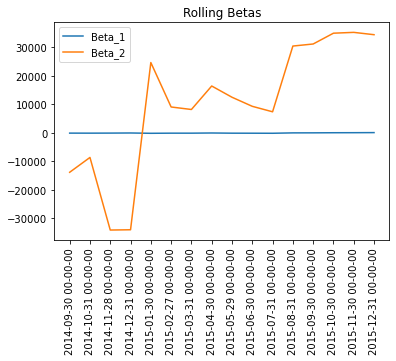

<Figure size 1440x144 with 0 Axes>

In [89]:
dependVar = sample_2['SMI Index']
independVar = sample_2[['CPI CHNG Index', 'USERTOT Index', 'NAPMNMI Index', 'CONSSENT Index', 'M2 Index']]

cdf = rolling_regression(dependVar,independVar,15)
cdf=pd.DataFrame.from_dict(OrderedDict(cdf), orient='index')
cdf['regressionId'] = 1
cdf.columns=["Beta_1","Beta_2","Beta_3", "Beta_4", "Beta_5", "RegressionId"]

plt.plot(cdf[["Beta_1", 'Beta_2']])
labels=["Beta_1","Beta_2","Beta_3", "Beta_4", "Beta_5"]
plt.legend(labels)
plt.title('Rolling Betas')
plt.xticks(rotation=90)
plt.figure(figsize=(20, 2))
plt.show
cdf.head(5)


# Check Correlation between the marco variables

In [263]:
corr = data[macroColumns].corr()

In [264]:
corr

,CPI CHNG Index,USERTOT Index,NAPMNMI Index,RSTAMOM Index,M2 Index,EUITEMU Index,CPMINORD Index,USGG10YR Index,CONSSENT Index,CONCCONF Index
CPI CHNG Index,1.000000,0.116132,0.261534,0.348134,-0.012462,0.331547,0.147957,0.188202,-0.053499,-0.006298
USERTOT Index,0.116132,1.000000,0.544187,-0.107868,-0.052483,0.831195,-0.106354,0.436163,0.685385,0.582447
NAPMNMI Index,0.261534,0.544187,1.000000,0.066164,0.106342,0.658955,0.145218,0.383880,0.497433,0.437401
RSTAMOM Index,0.348134,-0.107868,0.066164,1.000000,0.044591,0.073242,0.023396,-0.003697,-0.060330,-0.042316
M2 Index,-0.012462,-0.052483,0.106342,0.044591,1.000000,0.151630,-0.029808,-0.494269,0.449316,0.676449
EUITEMU Index,0.331547,0.831195,0.658955,0.073242,0.151630,1.000000,0.058625,0.422658,0.611318,0.611709
CPMINORD Index,0.147957,-0.106354,0.145218,0.023396,-0.029808,0.058625,1.000000,0.278842,-0.089296,-0.049668
USGG10YR Index,0.188202,0.436163,0.383880,-0.003697,-0.494269,0.422658,0.278842,1.000000,0.150379,0.071142
CONSSENT Index,-0.053499,0.685385,0.497433,-0.060330,0.449316,0.611318,-0.089296,0.150379,1.000000,0.897165
CONCCONF Index,-0.006298,0.582447,0.437401,-0.042316,0.676449,0.611709,-0.049668,0.071142,0.897165,1.000000


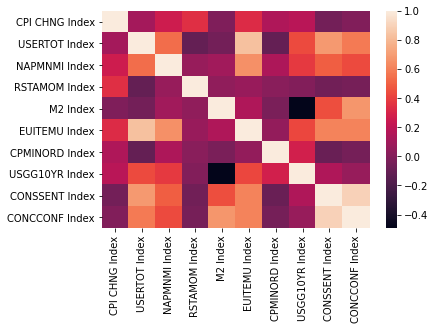

In [43]:
import seaborn as sns
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)